# Assignment 7 Classification


## Learning Objectives

* Identify classification learning algorithms in supervised learning paradigm
* Identify what is K-nearest neighbor (KNN)  and how it works
* Identify what is logistic regression  and how it works
* Apply KNN and logistic regression to build classifiers
* Analyze and communicate analysis results by applying classifiers to learn from data




## Provided Code

Below code, which is similar or identical to the lecture code, can be used in your assignment solutions.   Please feel free to use them as you see appropriate. Note that you can reuse as much code as possible from the lecture notes.  Indeed, I expect to reuse a lot of code, even if the code is not included below, from the lecture notes to approach the problems in this assignment.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#you can use the below style or something else
plt.style.use('classic')

In [2]:
#z-scaling.  The returned array should have mean 0 and std 1
def scaleAttrs(vals):
    vals = np.array(vals)
    mean = sum(vals)/len(vals)
    sd = np.std(vals)
    vals = vals - mean
    return vals/sd

In [3]:
def accuracy(truePos, falsePos, trueNeg, falseNeg):
    numerator = truePos + trueNeg
    denominator = truePos + trueNeg + falsePos + falseNeg
    return numerator/denominator
def sensitivity(truePos, falseNeg):
    try:
        return truePos/(truePos + falseNeg)
    except ZeroDivisionError:
        return float('nan')
def specificity(trueNeg, falsePos):
    try:
        return trueNeg/(trueNeg + falsePos)
    except ZeroDivisionError:
        return float('nan')
def posPredVal(truePos, falsePos):
    try:
        return truePos/(truePos + falsePos)
    except ZeroDivisionError:
        return float('nan')
def negPredVal(trueNeg, falseNeg):
    try:
        return trueNeg/(trueNeg + falseNeg)
    except ZeroDivisionError:
        return float('nan')

def getStats(truePos, falsePos, trueNeg, falseNeg, toPrint = True):
    accur = accuracy(truePos, falsePos, trueNeg, falseNeg)
    sens = sensitivity(truePos, falseNeg)
    spec = specificity(trueNeg, falsePos)
    ppv = posPredVal(truePos, falsePos)
    if toPrint:
        print(' Accuracy =', round(accur, 3))
        print(' Sensitivity =', round(sens, 3))
        print(' Specificity =', round(spec, 3))
        print(' Pos. Pred. Val. =', round(ppv, 3))
    return (accur, sens, spec, ppv)

def leaveOneOut(examples, method, toPrint = True):
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for i in range(len(examples)):
        testCase = examples[i]
        trainingData = examples[0:i] + examples[i+1:]
        results = method(trainingData, [testCase])
        truePos += results[0]
        falsePos += results[1]
        trueNeg += results[2]
        falseNeg += results[3]
    if toPrint:
        getStats(truePos, falsePos, trueNeg, falseNeg)
    return truePos, falsePos, trueNeg, falseNeg

def split80_20(examples):
    sampleIndices = random.sample(range(len(examples)),
                                  len(examples)//5)
    trainingSet, testSet = [], []
    for i in range(len(examples)):
        if i in sampleIndices:
            testSet.append(examples[i])
        else:
            trainingSet.append(examples[i])
    return trainingSet, testSet

# method is a function that could be k-nn or logistic-regression
def randomSplits(examples, method, numSplits, toPrint = True):
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    random.seed(0)
    for t in range(numSplits):
        trainingSet, testSet = split80_20(examples)
        results = method(trainingSet, testSet)
        truePos += results[0]
        falsePos += results[1]
        trueNeg += results[2]
        falseNeg += results[3]
    getStats(truePos/numSplits, falsePos/numSplits,trueNeg/numSplits, falseNeg/numSplits, toPrint)
    return truePos/numSplits, falsePos/numSplits,trueNeg/numSplits, falseNeg/numSplits

In [4]:

def minkowskiDist(v1, v2, p):
    """Assumes v1 and v2 are equal-length arrays of numbers
       Returns Minkowski distance of order p between v1 and v2"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**p
    return dist**(1/p)

In [5]:
#Now let's try KNN
def findKNearest(example, exampleSet, k):
    kNearest, distances = [], []
    #Build lists containing first k examples and their distances
    for i in range(k):
        kNearest.append(exampleSet[i])
        distances.append(example.distance(exampleSet[i]))
    maxDist = max(distances) #Get maximum distance
    #Look at examples not yet considered
    for e in exampleSet[k:]:
        dist = example.distance(e)
        if dist < maxDist:
            #replace farther neighbor by this one
            maxIndex = distances.index(maxDist)
            kNearest[maxIndex] = e
            distances[maxIndex] = dist
            maxDist = max(distances)
    return kNearest, distances

def KNearestClassify(training, testSet, label, k):
    """Assumes training & testSet lists of examples, k an int
       Predicts whether each example in testSet has label
       Returns number of true positives, false positives,
          true negatives, and false negatives"""
    truePos, falsePos, trueNeg, falseNeg = 0, 0, 0, 0
    for testCase in testSet:
        nearest, distances = findKNearest(testCase, training, k)
        #conduct vote
        numMatch = 0
        for i in range(len(nearest)):
            if nearest[i].getLabel() == label:
                numMatch += 1
        if numMatch > k//2: #guess label
            if testCase.getLabel() == label:
                truePos += 1
            else:
                falsePos += 1
        else: #guess not label
            if testCase.getLabel() != label:
                trueNeg += 1
            else:
                falseNeg += 1
    return truePos, falsePos, trueNeg, falseNeg


## Data Scientists

Assume that we have a data-science club where data scientists meet and discuss data analysis and visualization. The members in the club are either paid accounts or unpaid accounts.  You are provided a list of tuples.  Each tuple contains three elements:
* tenure, which is the number of years as a data scientist,
* salary, which is how much the data scientist earns,
* account, which is a number that is either 1 for a paid account or 0 for an unpaid account.



### Problem 1: Plotting the Club Members

For this problem, you need to plot the data scientists in the data-science club so that we can conveniently visualize their tenured years, salaries, and paid accounts or not. Note that this problem was approached in an earlier assignment. I expect you to explore the data while approaching the question.

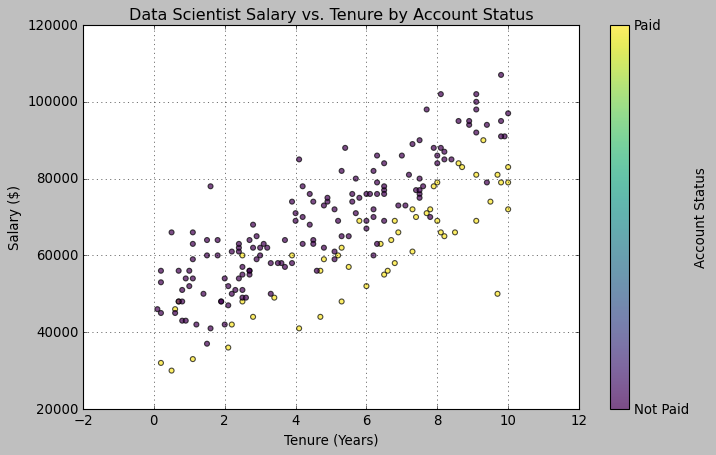

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


data = [(0.7,48000,1),(1.9,48000,0),(2.5,60000,1),(4.2,63000,0),(6,76000,0),(6.5,69000,0),(7.5,76000,0),(8.1,88000,0),(8.7,83000,1),(10,83000,1),(0.8,43000,0),(1.8,60000,0),(10,79000,1),(6.1,76000,0),(1.4,50000,0),(9.1,92000,0),(5.8,75000,0),(5.2,69000,0),(1,56000,0),(6,67000,0),(4.9,74000,0),(6.4,63000,1),(6.2,82000,0),(3.3,58000,0),(9.3,90000,1),(5.5,57000,1),(9.1,102000,0),(2.4,54000,0),(8.2,65000,1),(5.3,82000,0),(9.8,107000,0),(1.8,64000,0),(0.6,46000,1),(0.8,48000,0),(8.6,84000,1),(0.6,45000,0),(0.5,30000,1),(7.3,89000,0),(2.5,48000,1),(5.6,76000,0),(7.4,77000,0),(2.7,56000,0),(0.7,48000,0),(1.2,42000,0),(0.2,32000,1),(4.7,56000,1),(2.8,44000,1),(7.6,78000,0),(1.1,63000,0),(8,79000,1),(2.7,56000,0),(6,52000,1),(4.6,56000,0),(2.5,51000,0),(5.7,71000,0),(2.9,65000,0),(1.1,33000,1),(3,62000,0),(4,71000,0),(2.4,61000,0),(7.5,75000,0),(9.7,81000,1),(3.2,62000,0),(7.9,88000,0),(4.7,44000,1),(2.5,55000,0),(1.6,41000,0),(6.7,64000,1),(6.9,66000,1),(7.9,78000,1),(8.1,102000,0),(5.3,48000,1),(8.5,66000,1),(0.2,56000,0),(6,69000,0),(7.5,77000,0),(8,86000,0),(4.4,68000,0),(4.9,75000,0),(1.5,60000,0),(2.2,50000,0),(3.4,49000,1),(4.2,70000,0),(7.7,98000,0),(8.2,85000,0),(5.4,88000,0),(0.1,46000,0),(1.5,37000,0),(6.3,86000,0),(3.7,57000,0),(8.4,85000,0),(2,42000,0),(5.8,69000,1),(2.7,64000,0),(3.1,63000,0),(1.9,48000,0),(10,72000,1),(0.2,45000,0),(8.6,95000,0),(1.5,64000,0),(9.8,95000,0),(5.3,65000,0),(7.5,80000,0),(9.9,91000,0),(9.7,50000,1),(2.8,68000,0),(3.6,58000,0),(3.9,74000,0),(4.4,76000,0),(2.5,49000,0),(7.2,81000,0),(5.2,60000,1),(2.4,62000,0),(8.9,94000,0),(2.4,63000,0),(6.8,69000,1),(6.5,77000,0),(7,86000,0),(9.4,94000,0),(7.8,72000,1),(0.2,53000,0),(10,97000,0),(5.5,65000,0),(7.7,71000,1),(8.1,66000,1),(9.8,91000,0),(8,84000,0),(2.7,55000,0),(2.8,62000,0),(9.4,79000,0),(2.5,57000,0),(7.4,70000,1),(2.1,47000,0),(5.3,62000,1),(6.3,79000,0),(6.8,58000,1),(5.7,80000,0),(2.2,61000,0),(4.8,62000,0),(3.7,64000,0),(4.1,85000,0),(2.3,51000,0),(3.5,58000,0),(0.9,43000,0),(0.9,54000,0),(4.5,74000,0),(6.5,55000,1),(4.1,41000,1),(7.1,73000,0),(1.1,66000,0),(9.1,81000,1),(8,69000,1),(7.3,72000,1),(3.3,50000,0),(3.9,58000,0),(2.6,49000,0),(1.6,78000,0),(0.7,56000,0),(2.1,36000,1),(7.5,90000,0),(4.8,59000,1),(8.9,95000,0),(6.2,72000,0),(6.3,63000,0),(9.1,100000,0),(7.3,61000,1),(5.6,74000,0),(0.5,66000,0),(1.1,59000,0),(5.1,61000,0),(6.2,70000,0),(6.6,56000,1),(6.3,76000,0),(6.5,78000,0),(5.1,59000,0),(9.5,74000,1),(4.5,64000,0),(2,54000,0),(1,52000,0),(4,69000,0),(6.5,76000,0),(3,60000,0),(4.5,63000,0),(7.8,70000,0),(3.9,60000,1),(0.8,51000,0),(4.2,78000,0),(1.1,54000,0),(6.2,60000,0),(2.9,59000,0),(2.1,52000,0),(8.2,87000,0),(4.8,73000,0),(2.2,42000,1),(9.1,98000,0),(6.5,84000,0),(6.9,73000,0),(5.1,72000,0),(9.1,69000,1),(9.8,79000,1),]

df = pd.DataFrame(data, columns=['Tenure', 'Salary', 'Paid_Account'])


df['Account_Status'] = df['Paid_Account'].apply(lambda x: 'Paid' if x == 1 else 'Not Paid')


plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Tenure'], df['Salary'], c=df['Paid_Account'], cmap='viridis', alpha=0.7)


plt.xlabel('Tenure (Years)')
plt.ylabel('Salary ($)')
plt.title('Data Scientist Salary vs. Tenure by Account Status')


cbar = plt.colorbar(scatter)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Not Paid', 'Paid'])
cbar.set_label('Account Status')


plt.grid(True)

# Show the plot
plt.show()

### Problem 2  Preparing for Building Learning Algorithms

For this problem, you need to write functions/class definition(s) to prepare building classifiers and testing them using various metrics including accuracy, sensitivity, specificity, positive predicative value, negative predictive value.  In addition, you need to define a class **DataScientist** from which you can create data examples.  Each example represents a data scientist in terms of its features including salary and tenured years.  Your class definition also needs to allow you label a data scientist to appropriately distinguish paid from unpaid accounts in the club. **Your class definition should be clear about what features are used in a feature vector and what is your label attribute for each data example**.

After you complete your class DataScientist definition, you need to process the provided data into a list of data examples. (Each example is a data scientist.)  



In [7]:
class DataScientist:
    """
    Represents a data scientist with features and a label for classification.

    Attributes:
        tenure (float): The number of years tenured.
        salary (int): The annual salary.
        label (int): The account status (1 for paid, 0 for not paid).
        feature_vector (list): A list containing the numerical features [tenure, salary].
    """
    def __init__(self, tenure, salary, label):
        self.tenure = tenure
        self.salary = salary
        self.label = label
        self.feature_vector = [tenure, salary]

    def __repr__(self):
        return f"DataScientist(tenure={self.tenure}, salary={self.salary}, label={self.label})"


data = [(0.7,48000,1),(1.9,48000,0),(2.5,60000,1),(4.2,63000,0),(6,76000,0),(6.5,69000,0),(7.5,76000,0),(8.1,88000,0),(8.7,83000,1),(10,83000,1),(0.8,43000,0),(1.8,60000,0),(10,79000,1),(6.1,76000,0),(1.4,50000,0),(9.1,92000,0),(5.8,75000,0),(5.2,69000,0),(1,56000,0),(6,67000,0),(4.9,74000,0),(6.4,63000,1),(6.2,82000,0),(3.3,58000,0),(9.3,90000,1),(5.5,57000,1),(9.1,102000,0),(2.4,54000,0),(8.2,65000,1),(5.3,82000,0),(9.8,107000,0),(1.8,64000,0),(0.6,46000,1),(0.8,48000,0),(8.6,84000,1),(0.6,45000,0),(0.5,30000,1),(7.3,89000,0),(2.5,48000,1),(5.6,76000,0),(7.4,77000,0),(2.7,56000,0),(0.7,48000,0),(1.2,42000,0),(0.2,32000,1),(4.7,56000,1),(2.8,44000,1),(7.6,78000,0),(1.1,63000,0),(8,79000,1),(2.7,56000,0),(6,52000,1),(4.6,56000,0),(2.5,51000,0),(5.7,71000,0),(2.9,65000,0),(1.1,33000,1),(3,62000,0),(4,71000,0),(2.4,61000,0),(7.5,75000,0),(9.7,81000,1),(3.2,62000,0),(7.9,88000,0),(4.7,44000,1),(2.5,55000,0),(1.6,41000,0),(6.7,64000,1),(6.9,66000,1),(7.9,78000,1),(8.1,102000,0),(5.3,48000,1),(8.5,66000,1),(0.2,56000,0),(6,69000,0),(7.5,77000,0),(8,86000,0),(4.4,68000,0),(4.9,75000,0),(1.5,60000,0),(2.2,50000,0),(3.4,49000,1),(4.2,70000,0),(7.7,98000,0),(8.2,85000,0),(5.4,88000,0),(0.1,46000,0),(1.5,37000,0),(6.3,86000,0),(3.7,57000,0),(8.4,85000,0),(2,42000,0),(5.8,69000,1),(2.7,64000,0),(3.1,63000,0),(1.9,48000,0),(10,72000,1),(0.2,45000,0),(8.6,95000,0),(1.5,64000,0),(9.8,95000,0),(5.3,65000,0),(7.5,80000,0),(9.9,91000,0),(9.7,50000,1),(2.8,68000,0),(3.6,58000,0),(3.9,74000,0),(4.4,76000,0),(2.5,49000,0),(7.2,81000,0),(5.2,60000,1),(2.4,62000,0),(8.9,94000,0),(2.4,63000,0),(6.8,69000,1),(6.5,77000,0),(7,86000,0),(9.4,94000,0),(7.8,72000,1),(0.2,53000,0),(10,97000,0),(5.5,65000,0),(7.7,71000,1),(8.1,66000,1),(9.8,91000,0),(8,84000,0),(2.7,55000,0),(2.8,62000,0),(9.4,79000,0),(2.5,57000,0),(7.4,70000,1),(2.1,47000,0),(5.3,62000,1),(6.3,79000,0),(6.8,58000,1),(5.7,80000,0),(2.2,61000,0),(4.8,62000,0),(3.7,64000,0),(4.1,85000,0),(2.3,51000,0),(3.5,58000,0),(0.9,43000,0),(0.9,54000,0),(4.5,74000,0),(6.5,55000,1),(4.1,41000,1),(7.1,73000,0),(1.1,66000,0),(9.1,81000,1),(8,69000,1),(7.3,72000,1),(3.3,50000,0),(3.9,58000,0),(2.6,49000,0),(1.6,78000,0),(0.7,56000,0),(2.1,36000,1),(7.5,90000,0),(4.8,59000,1),(8.9,95000,0),(6.2,72000,0),(6.3,63000,0),(9.1,100000,0),(7.3,61000,1),(5.6,74000,0),(0.5,66000,0),(1.1,59000,0),(5.1,61000,0),(6.2,70000,0),(6.6,56000,1),(6.3,76000,0),(6.5,78000,0),(5.1,59000,0),(9.5,74000,1),(4.5,64000,0),(2,54000,0),(1,52000,0),(4,69000,0),(6.5,76000,0),(3,60000,0),(4.5,63000,0),(7.8,70000,0),(3.9,60000,1),(0.8,51000,0),(4.2,78000,0),(1.1,54000,0),(6.2,60000,0),(2.9,59000,0),(2.1,52000,0),(8.2,87000,0),(4.8,73000,0),(2.2,42000,1),(9.1,98000,0),(6.5,84000,0),(6.9,73000,0),(5.1,72000,0),(9.1,69000,1),(9.8,79000,1),]


data_scientists = [DataScientist(d[0], d[1], d[2]) for d in data]

# Display the first few data examples
print("First 5 data examples:")
for i in range(min(5, len(data_scientists))):
    print(data_scientists[i])

First 5 data examples:
DataScientist(tenure=0.7, salary=48000, label=1)
DataScientist(tenure=1.9, salary=48000, label=0)
DataScientist(tenure=2.5, salary=60000, label=1)
DataScientist(tenure=4.2, salary=63000, label=0)
DataScientist(tenure=6, salary=76000, label=0)


### Problem 3 Logistic Regression

In this problem, you need to write function(s) to build a classifier using logistic regression algorithm implemented in **sklearn.linear_model.LogisticRegression**.  You cannot use other library function on logistic regression to approach the problem.  Then, you need to apply the test methods (**leaveOneOut and randomSplit**) to evaluate the learned classifier in terms of accuracy, sensitivity, specificity, and positive predicative value.

The output of your evaluation on the logistic-regression classifier you built could be similar to the below, assuming the salary and tenured year values are scaled to values that have mean 0 and std 1 and the probability threshold for positive examples (paid accounts) is set as 0.3.

To scale the values, you can apply the function scaleAttrs.  You can also apply code that defines the test methods and measures.  The function definitions are provided above in the Reference Code section. I recommend you to review the lecture if you need to figure what and how they can applied in a classification system.

More Hint: In addition to the code provided in this document, you will need to reference the code in lecture that is used to build a model using logistic regression, apply the model, and evaluate the model.  

```
Average of 10 80/20 splits LR
 Accuracy = 0.857
 Sensitivity = 0.881
 Specificity = 0.849
 Pos. Pred. Val. = 0.664
Average of LOO testing using LR
 Accuracy = 0.865
 Sensitivity = 0.846
 Specificity = 0.872
 Pos. Pred. Val. = 0.698

 ```

In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter


def calculate_metrics(true_labels, predicted_labels):
    """
    Calculates classification metrics: accuracy, sensitivity, specificity, PPV, NPV.

    Args:
        true_labels (list): The actual labels.
        predicted_labels (list): The predicted labels from the classifier.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
    TP = np.sum((true_labels == 1) & (predicted_labels == 1))
    TN = np.sum((true_labels == 0) & (predicted_labels == 0))
    FP = np.sum((true_labels == 0) & (predicted_labels == 1))
    FN = np.sum((true_labels == 1) & (predicted_labels == 0))

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0  
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0

    return {
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Pos. Pred. Val.": ppv,
        "Neg. Pred. Val.": npv
    }


def scale_features(data_scientists):
    """
    Scales the feature vectors of DataScientist objects using StandardScaler.

    Args:
        data_scientists (list): A list of DataScientist objects.

    Returns:
        tuple: A tuple containing:
            - scaled_features (np.ndarray): The scaled feature vectors.
            - original_labels (list): The original labels.
    """

    features = [ds.feature_vector for ds in data_scientists]
    labels = [ds.label for ds in data_scientists]


    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    return scaled_features, labels


def build_logistic_regression_classifier(train_features, train_labels):
    """
    Builds and trains a Logistic Regression classifier.

    Args:
        train_features (np.ndarray): The training feature data.
        train_labels (list): The training labels.

    Returns:
        LogisticRegression: The trained Logistic Regression model.
    """
    model = LogisticRegression()
    model.fit(train_features, train_labels)
    return model



def leave_one_out_test(data_scientists, classifier_builder_func, probability_threshold=0.5):
    """
    Evaluates a classifier using Leave-One-Out cross-validation.

    Args:
        data_scientists (list): A list of DataScientist objects.
        classifier_builder_func (function): A function that builds and returns a trained classifier.
        probability_threshold (float): The threshold for classifying a positive example.

    Returns:
        dict: A dictionary containing the average metrics from LOO testing.
    """
    loo = LeaveOneOut()
    true_labels = []
    predicted_labels = []

    scaled_features, original_labels = scale_features(data_scientists)

    for train_index, test_index in loo.split(scaled_features):

        X_train, X_test = scaled_features[train_index], scaled_features[test_index]
        y_train, y_test = [original_labels[i] for i in train_index], [original_labels[i] for i in test_index]


        classifier = classifier_builder_func(X_train, y_train)


        y_pred_proba = classifier.predict_proba(X_test)[:, 1] 


        y_pred = (y_pred_proba >= probability_threshold).astype(int)


        true_labels.extend(y_test)
        predicted_labels.extend(y_pred)

    average_metrics = calculate_metrics(true_labels, predicted_labels)
    return average_metrics

def random_split_test(data_scientists, classifier_builder_func, num_splits=10, train_size=0.8, probability_threshold=0.5):
    """
    Evaluates a classifier using random train/test splits.

    Args:
        data_scientists (list): A list of DataScientist objects.
        classifier_builder_func (function): A function that builds and returns a trained classifier.
        num_splits (int): The number of random splits to perform.
        train_size (float): The proportion of the dataset to include in the train split.
        probability_threshold (float): The threshold for classifying a positive example.

    Returns:
        dict: A dictionary containing the average metrics over all random splits.
    """
    all_true_labels = []
    all_predicted_labels = []


    scaled_features, original_labels = scale_features(data_scientists)

    for _ in range(num_splits):
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_features, original_labels, train_size=train_size, stratify=original_labels
        )


        classifier = classifier_builder_func(X_train, y_train)


        y_pred_proba = classifier.predict_proba(X_test)[:, 1]

        y_pred = (y_pred_proba >= probability_threshold).astype(int)


        all_true_labels.extend(y_test)
        all_predicted_labels.extend(y_pred)

    average_metrics = calculate_metrics(all_true_labels, all_predicted_labels)
    return average_metrics


probability_threshold = 0.3

print(f"Evaluating Logistic Regression with probability threshold = {probability_threshold}\n")


print(f"Average of 10 80/20 splits using LR (threshold={probability_threshold})")
random_split_metrics = random_split_test(
    data_scientists,
    build_logistic_regression_classifier,
    num_splits=10,
    train_size=0.8,
    probability_threshold=probability_threshold
)
for metric, value in random_split_metrics.items():
    print(f" {metric} = {value:.3f}")

print("\n" + "="*30 + "\n")


print(f"Average of LOO testing using LR (threshold={probability_threshold})")
loo_metrics = leave_one_out_test(
    data_scientists,
    build_logistic_regression_classifier,
    probability_threshold=probability_threshold
)
for metric, value in loo_metrics.items():
    print(f" {metric} = {value:.3f}")



Evaluating Logistic Regression with probability threshold = 0.3

Average of 10 80/20 splits using LR (threshold=0.3)
 Accuracy = 0.838
 Sensitivity = 0.810
 Specificity = 0.847
 Pos. Pred. Val. = 0.638
 Neg. Pred. Val. = 0.930


Average of LOO testing using LR (threshold=0.3)
 Accuracy = 0.865
 Sensitivity = 0.846
 Specificity = 0.872
 Pos. Pred. Val. = 0.698
 Neg. Pred. Val. = 0.942


### Problem 4 KNN

In this problem, you need to write function(s) to build a classifier using KNN algorithm.  Your implementation needs to be based on the provided **KNearestClassify** defined earlier in this document.  Then, you need to apply the test methods (**leaveOneOut and randomSplit**) to evaluate the learned classifer in terms of accuracy, sensitivity, specificity, and positive predicative value.

More Hint: In addition to the code provided in this document, you will need to reference the code in lecture that is used to define KNN, apply KNN, and evaluate the classification result. You cannot use any library KNN function to approach the problem.  

The output of your evaluation on the KNN classifier you built could be similar to the below, assuming the positive examples are paid accounts:
```
Average of 10 80/20 splits using KNN (k=5)
 Accuracy = 0.848
 Sensitivity = 0.574
 Specificity = 0.94
 Pos. Pred. Val. = 0.763
Average of LOO testing using KNN (k=5)
 Accuracy = 0.865
 Sensitivity = 0.596
 Specificity = 0.959
 Pos. Pred. Val. = 0.838


 ```

In [9]:
import numpy as np
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import math


def calculate_metrics(true_labels, predicted_labels):
    """
    Calculates classification metrics: accuracy, sensitivity, specificity, PPV, NPV.

    Args:
        true_labels (list): The actual labels.
        predicted_labels (list): The predicted labels from the classifier.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    TP = np.sum((true_labels == 1) & (predicted_labels == 1))
    TN = np.sum((true_labels == 0) & (predicted_labels == 0))
    FP = np.sum((true_labels == 0) & (predicted_labels == 1))
    FN = np.sum((true_labels == 1) & (predicted_labels == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0

    return {
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Pos. Pred. Val.": ppv,
        "Neg. Pred. Val.": npv
    }

def scale_features(data_scientists):
    """
    Scales the feature vectors of DataScientist objects using StandardScaler.

    Args:
        data_scientists (list): A list of DataScientist objects.

    Returns:
        tuple: A tuple containing:
            - scaled_features (np.ndarray): The scaled feature vectors.
            - original_labels (list): The original labels.
    """
    features = [ds.feature_vector for ds in data_scientists]
    labels = [ds.label for ds in data_scientists]

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    return scaled_features, labels

def euclidean_distance(point1, point2):
    """
    Calculates the Euclidean distance between two points (feature vectors).

    Args:
        point1 (list or np.ndarray): The first point's coordinates.
        point2 (list or np.ndarray): The second point's coordinates.

    Returns:
        float: The Euclidean distance between the two points.
    """
    distance = 0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i])**2
    return math.sqrt(distance)

def KNearestClassify(train_data, test_instance, k):
    """
    Classifies a test instance using the K-Nearest Neighbors algorithm.

    Args:
        train_data (list of tuples): A list of training examples, where each example
                                     is a tuple (feature_vector, label).
        test_instance (list or np.ndarray): The feature vector of the test instance.
        k (int): The number of neighbors to consider.

    Returns:
        int: The predicted label for the test instance (0 or 1).
    """
    distances = []

    for train_instance, label in train_data:
        dist = euclidean_distance(test_instance, train_instance)
        distances.append((dist, label))


    distances.sort(key=lambda x: x[0])


    k_nearest_neighbors_labels = [label for dist, label in distances[:k]]


    label_counts = Counter(k_nearest_neighbors_labels)


    predicted_label = label_counts.most_common(1)[0][0]

    return predicted_label


class KNNClassifierWrapper:
    """
    A wrapper class for the KNearestClassify function to fit the classifier
    interface expected by the testing functions.
    """
    def __init__(self, k=5):
        self.k = k
        self.train_data = None 

    def fit(self, train_features, train_labels):
        """
        Stores the training data.

        Args:
            train_features (np.ndarray): The training feature data.
            train_labels (list): The training labels.
        """
        self.train_data = list(zip(train_features, train_labels))

    def predict(self, test_features):
        """
        Predicts labels for test instances using KNearestClassify.

        Args:
            test_features (np.ndarray): The test feature data.

        Returns:
            list: The predicted labels for the test instances.
        """
        predictions = []
        for test_instance in test_features:
            predicted_label = KNearestClassify(self.train_data, test_instance, self.k)
            predictions.append(predicted_label)
        return predictions


def build_knn_classifier(train_features, train_labels, k=5):
    """
    Builds and "trains" (stores data for) the KNN classifier wrapper.

    Args:
        train_features (np.ndarray): The training feature data.
        train_labels (list): The training labels.
        k (int): The number of neighbors for KNN.

    Returns:
        KNNClassifierWrapper: The initialized KNN classifier wrapper.
    """
    knn_wrapper = KNNClassifierWrapper(k=k)
    knn_wrapper.fit(train_features, train_labels)
    return knn_wrapper


def leave_one_out_test(data_scientists, classifier_builder_func, **kwargs):
    """
    Evaluates a classifier using Leave-One-Out cross-validation.

    Args:
        data_scientists (list): A list of DataScientist objects.
        classifier_builder_func (function): A function that builds and returns a trained classifier.
        **kwargs: Arbitrary keyword arguments to pass to the classifier_builder_func.

    Returns:
        dict: A dictionary containing the average metrics from LOO testing.
    """
    loo = LeaveOneOut()
    true_labels = []
    predicted_labels = []

    scaled_features, original_labels = scale_features(data_scientists)

    for train_index, test_index in loo.split(scaled_features):
        X_train, X_test = scaled_features[train_index], scaled_features[test_index]
        y_train, y_test = [original_labels[i] for i in train_index], [original_labels[i] for i in test_index]


        classifier = classifier_builder_func(X_train, y_train, **kwargs)


        y_pred = classifier.predict(X_test)

        true_labels.extend(y_test)
        predicted_labels.extend(y_pred)

    average_metrics = calculate_metrics(true_labels, predicted_labels)
    return average_metrics

def random_split_test(data_scientists, classifier_builder_func, num_splits=10, train_size=0.8, **kwargs):
    """
    Evaluates a classifier using random train/test splits.

    Args:
        data_scientists (list): A list of DataScientist objects.
        classifier_builder_func (function): A function that builds and returns a trained classifier.
        num_splits (int): The number of random splits to perform.
        train_size (float): The proportion of the dataset to include in the train split.
        **kwargs: Arbitrary keyword arguments to pass to the classifier_builder_func.

    Returns:
        dict: A dictionary containing the average metrics over all random splits.
    """
    all_true_labels = []
    all_predicted_labels = []

    scaled_features, original_labels = scale_features(data_scientists)

    for _ in range(num_splits):

        X_train, X_test, y_train, y_test = train_test_split(
            scaled_features, original_labels, train_size=train_size, stratify=original_labels
        )

        classifier = classifier_builder_func(X_train, y_train, **kwargs)


        y_pred = classifier.predict(X_test)


        all_true_labels.extend(y_test)
        all_predicted_labels.extend(y_pred)


    average_metrics = calculate_metrics(all_true_labels, all_predicted_labels)
    return average_metrics


k_neighbors = 5

print(f"Evaluating KNN Classifier with k = {k_neighbors}\n")

print(f"Average of 10 80/20 splits using KNN (k={k_neighbors})")
random_split_metrics_knn = random_split_test(
    data_scientists,
    build_knn_classifier,
    num_splits=10,
    train_size=0.8,
    k=k_neighbors 
)
for metric, value in random_split_metrics_knn.items():
    print(f" {metric} = {value:.3f}")

print("\n" + "="*30 + "\n")

print(f"Average of LOO testing using KNN (k={k_neighbors})")
loo_metrics_knn = leave_one_out_test(
    data_scientists,
    build_knn_classifier,
    k=k_neighbors
)
for metric, value in loo_metrics_knn.items():
    print(f" {metric} = {value:.3f}")



Evaluating KNN Classifier with k = 5

Average of 10 80/20 splits using KNN (k=5)
 Accuracy = 0.880
 Sensitivity = 0.610
 Specificity = 0.970
 Pos. Pred. Val. = 0.871
 Neg. Pred. Val. = 0.882


Average of LOO testing using KNN (k=5)
 Accuracy = 0.865
 Sensitivity = 0.596
 Specificity = 0.959
 Pos. Pred. Val. = 0.838
 Neg. Pred. Val. = 0.871


## Loan

In the following problems, you will analyze a set of loan data points.  Each data point is presented as a row in the data file (loan_data.csv). You can download the data file from the assignment folder at D2L web site. Each row contains the customer data including id, outcome, dti, borrower_score, and payment_inc_ratio. The **loan outcome** should be used to label the data point for your classifier.  You should **not** use id as a feature for your feature vectors.



In [10]:
 import csv
import io

class LoanData:
    """
    Represents a loan data point with features and an outcome label.

    Attributes:
        outcome (str): The outcome of the loan (e.g., 'paid off', 'default').
        dti (float): Debt-to-income ratio.
        borrower_score (float): A score representing the borrower's creditworthiness.
        payment_inc_ratio (float): Payment-to-income ratio.
        feature_vector (list): A list containing the numerical features [dti, borrower_score, payment_inc_ratio].
    """
    def __init__(self, outcome, dti, borrower_score, payment_inc_ratio):
        self.outcome = outcome
        self.dti = float(dti)
        self.borrower_score = float(borrower_score)
        self.payment_inc_ratio = float(payment_inc_ratio)
        self.feature_vector = [self.dti, self.borrower_score, self.payment_inc_ratio]

    def __repr__(self):
        return f"LoanData(outcome='{self.outcome}', dti={self.dti}, borrower_score={self.borrower_score}, payment_inc_ratio={self.payment_inc_ratio})"


file_path = 'loan_data.csv'

loan_data_points = []

try:
    with open(file_path, mode='r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)

        header = next(csv_reader)

        for row in csv_reader:
            if len(row) >= 5:
                 loan_data_points.append(LoanData(row[1], row[2], row[3], row[4]))

    print(f"Successfully loaded {len(loan_data_points)} loan data points from {file_path}.")

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    loan_data_points = []
except Exception as e:
    print(f"An error occurred while processing the file: {e}")
    loan_data_points = []



Successfully loaded 3000 loan data points from loan_data.csv.


### Problem 5  Preparing for Building Learning Algorithms

For this problem, you need to write functions/class definition(s) to prepare building classifiers and testing them using various metrics including accuracy, sensitivity, specificity, positive predicative value, negative predictive value. In Problem 2, you are also required to define the metric functions. So, you can reuse the functions you defined there. In addition, you need to define a class Customer from which you can create data examples.  Each example represents a Customer in terms of its features.  Your class definition also needs to allow you label a customer appropriately based on the loan outcome "paid off" or "default". **Your class definition should be clear about what features are used in a feature vector and what is your label attribute for each data example**.

After you complete your class Customer definition, you need to process the provided data into a list of data examples. (Each example is a customer.)  

Again, I would emphasize that you can reuse as much code as possible from the lecture notes and share your code to solve the problems in this assignment.  

In [11]:
import csv
import io

class Customer:
    """
    Represents a customer with loan data features and an outcome label.

    Attributes:
        outcome (str): The outcome of the loan ('paid off' or 'default').
        dti (float): Debt-to-income ratio.
        borrower_score (float): A score representing the borrower's creditworthiness.
        payment_inc_ratio (float): Payment-to-income ratio.
        feature_vector (list): A list containing the numerical features [dti, borrower_score, payment_inc_ratio].
    """
    def __init__(self, outcome, dti, borrower_score, payment_inc_ratio):
        self.outcome = outcome
        try:
            self.dti = float(dti)
            self.borrower_score = float(borrower_score)
            self.payment_inc_ratio = float(payment_inc_ratio)
        except ValueError as e:
            print(f"Error converting data to float for row with outcome '{outcome}': {e}")
            self.dti = 0.0
            self.borrower_score = 0.0
            self.payment_inc_ratio = 0.0

        self.feature_vector = [self.dti, self.borrower_score, self.payment_inc_ratio]

    def __repr__(self):
        return f"Customer(outcome='{self.outcome}', dti={self.dti}, borrower_score={self.borrower_score}, payment_inc_ratio={self.payment_inc_ratio})"

file_path = 'loan_data.csv'

customer_data_points = []

try:
    with open(file_path, mode='r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)


        for row in csv_reader:
            if len(row) >= 5: 
                 customer_data_points.append(Customer(row[1], row[2], row[3], row[4]))


    print(f"Successfully loaded {len(customer_data_points)} customer data points from {file_path}.")


except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    customer_data_points = []
except Exception as e:
    print(f"An error occurred while processing the file: {e}")
    customer_data_points = []


Successfully loaded 3000 customer data points from loan_data.csv.


### Problem 6 Logistic Regression

In this problem, you need to write function(s) to build a classifier using logistic regression algorithm implemented in **sklearn.linear_model.LogisticRegression**.  Then, you need to apply the test methods (**leaveOneOut and randomSplit**) to evaluate the learned classifier in terms of accuracy, sensitivity, specificity, and positive predicative value.

 Additionally, you need to plot the ROC curve and compute the AUC score to evaluate your classifier.  

Successfully loaded 3000 customer data points from loan_data.csv.
Evaluating Logistic Regression Classifier for Loan Data

Average of 10 80/20 splits using LR (default threshold)
 Accuracy = 0.628
 Sensitivity = 0.668
 Specificity = 0.585
 Pos. Pred. Val. = 0.634
 Neg. Pred. Val. = 0.621


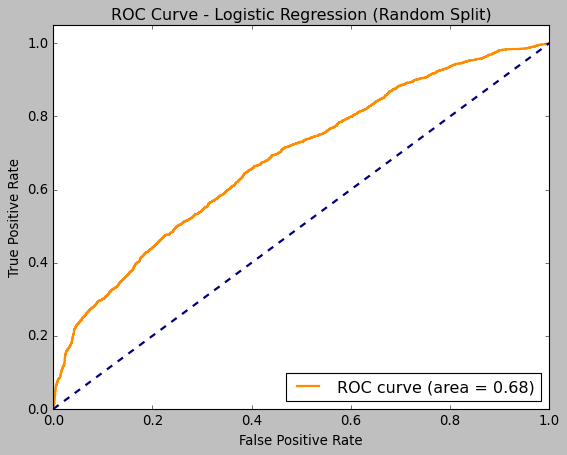

AUC: 0.682


Average of LOO testing using LR (default threshold)
 Accuracy = 0.629
 Sensitivity = 0.664
 Specificity = 0.590
 Pos. Pred. Val. = 0.636
 Neg. Pred. Val. = 0.620


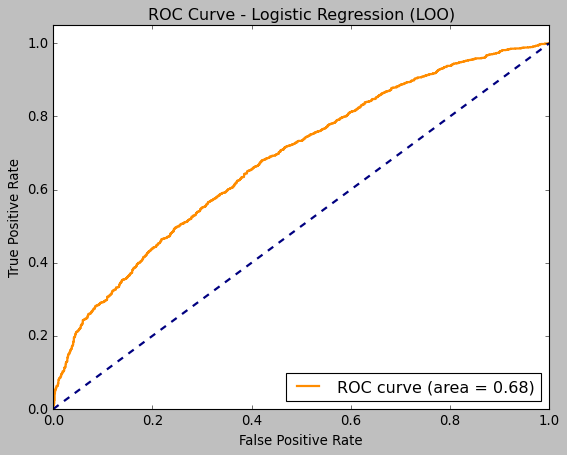

AUC: 0.683


In [12]:
import csv
import io
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class Customer:
    """
    Represents a customer with loan data features and an outcome label.

    Attributes:
        outcome (str): The outcome of the loan ('paid off' or 'default'). This is the label.
        dti (float): Debt-to-income ratio.
        borrower_score (float): A score representing the borrower's creditworthiness.
        payment_inc_ratio (float): Payment-to-income ratio.
        feature_vector (list): A list containing the numerical features [dti, borrower_score, payment_inc_ratio].
    """
    def __init__(self, outcome, dti, borrower_score, payment_inc_ratio):
        self.outcome = outcome
        try:
            self.dti = float(dti)
            self.borrower_score = float(borrower_score)
            self.payment_inc_ratio = float(payment_inc_ratio)
        except ValueError as e:
            print(f"Error converting data to float for row with outcome '{outcome}': {e}")
            self.dti = 0.0
            self.borrower_score = 0.0
            self.payment_inc_ratio = 0.0

        self.feature_vector = [self.dti, self.borrower_score, self.payment_inc_ratio]

    def __repr__(self):
        return f"Customer(outcome='{self.outcome}', dti={self.dti}, borrower_score={self.borrower_score}, payment_inc_ratio={self.payment_inc_ratio})"

file_path = 'loan_data.csv'

customer_data_points = []

try:
    with open(file_path, mode='r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)

        header = next(csv_reader)

        for row in csv_reader:
            if len(row) >= 5:
                 customer_data_points.append(Customer(row[1], row[2], row[3], row[4]))

    print(f"Successfully loaded {len(customer_data_points)} customer data points from {file_path}.")

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    customer_data_points = []
except Exception as e:
    print(f"An error occurred while processing the file: {e}")
    customer_data_points = []

def calculate_metrics(true_labels, predicted_labels):
    """
    Calculates classification metrics: accuracy, sensitivity, specificity, PPV, NPV.

    Args:
        true_labels (list): The actual labels (0 or 1).
        predicted_labels (list): The predicted labels from the classifier (0 or 1).

    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    TP = np.sum((true_labels == 1) & (predicted_labels == 1))
    TN = np.sum((true_labels == 0) & (predicted_labels == 0))
    FP = np.sum((true_labels == 0) & (predicted_labels == 1))
    FN = np.sum((true_labels == 1) & (predicted_labels == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0

    return {
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Pos. Pred. Val.": ppv,
        "Neg. Pred. Val.": npv
    }

def scale_features_and_labels(customer_data_points):
    """
    Scales the feature vectors and converts string labels to numerical labels (0 or 1).

    Args:
        customer_data_points (list): A list of Customer objects.

    Returns:
        tuple: A tuple containing:
            - scaled_features (np.ndarray): The scaled feature vectors.
            - numerical_labels (list): The numerical labels (1 for 'paid off', 0 for 'default').
    """
    features = [customer.feature_vector for customer in customer_data_points]
    numerical_labels = [1 if customer.outcome == 'paid off' else 0 for customer in customer_data_points]

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    return scaled_features, numerical_labels

def build_logistic_regression_classifier(train_features, train_labels, **kwargs):
    """
    Builds and trains a Logistic Regression classifier.

    Args:
        train_features (np.ndarray): The training feature data.
        train_labels (list): The training labels (0 or 1).
        **kwargs: Arbitrary keyword arguments for LogisticRegression (e.g., C, penalty).

    Returns:
        LogisticRegression: The trained Logistic Regression model.
    """
    model = LogisticRegression(**kwargs)
    model.fit(train_features, train_labels)
    return model

def leave_one_out_test(customer_data_points, classifier_builder_func, **kwargs):
    """
    Evaluates a classifier using Leave-One-Out cross-validation.

    Args:
        customer_data_points (list): A list of Customer objects.
        classifier_builder_func (function): A function that builds and returns a trained classifier.
        **kwargs: Arbitrary keyword arguments to pass to the classifier_builder_func.

    Returns:
        tuple: A tuple containing:
            - average_metrics (dict): A dictionary containing the average metrics from LOO testing.
            - all_true_labels (list): List of all true labels.
            - all_predicted_probabilities (list): List of predicted probabilities for the positive class.
    """
    loo = LeaveOneOut()
    all_true_labels = []
    all_predicted_labels = []
    all_predicted_probabilities = []

    scaled_features, numerical_labels = scale_features_and_labels(customer_data_points)

    for train_index, test_index in loo.split(scaled_features):
        X_train, X_test = scaled_features[train_index], scaled_features[test_index]
        y_train, y_test = [numerical_labels[i] for i in train_index], [numerical_labels[i] for i in test_index]

        classifier = classifier_builder_func(X_train, y_train, **kwargs)

        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        y_pred = classifier.predict(X_test)

        all_true_labels.extend(y_test)
        all_predicted_labels.extend(y_pred)
        all_predicted_probabilities.extend(y_pred_proba)

    average_metrics = calculate_metrics(all_true_labels, all_predicted_labels)

    return average_metrics, all_true_labels, all_predicted_probabilities


def random_split_test(customer_data_points, classifier_builder_func, num_splits=10, train_size=0.8, **kwargs):
    """
    Evaluates a classifier using random train/test splits.

    Args:
        customer_data_points (list): A list of Customer objects.
        classifier_builder_func (function): A function that builds and returns a trained classifier.
        num_splits (int): The number of random splits to perform.
        train_size (float): The proportion of the dataset to include in the train split.
        **kwargs: Arbitrary keyword arguments to pass to the classifier_builder_func.

    Returns:
        tuple: A tuple containing:
            - average_metrics (dict): A dictionary containing the average metrics over all random splits.
            - all_true_labels (list): List of all true labels (aggregated across splits).
            - all_predicted_probabilities (list): List of predicted probabilities for the positive class (aggregated across splits).
    """
    all_true_labels = []
    all_predicted_labels = []
    all_predicted_probabilities = []

    scaled_features, numerical_labels = scale_features_and_labels(customer_data_points)

    for _ in range(num_splits):
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_features, numerical_labels, train_size=train_size, stratify=numerical_labels
        )

        classifier = classifier_builder_func(X_train, y_train, **kwargs)

        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        y_pred = classifier.predict(X_test)

        all_true_labels.extend(y_test)
        all_predicted_labels.extend(y_pred)
        all_predicted_probabilities.extend(y_pred_proba)

    average_metrics = calculate_metrics(all_true_labels, all_predicted_labels)

    return average_metrics, all_true_labels, all_predicted_probabilities

def plot_roc_curve(true_labels, predicted_probabilities, title="ROC Curve"):
    """
    Plots the ROC curve and calculates the AUC score.

    Args:
        true_labels (list): The actual labels (0 or 1).
        predicted_probabilities (list): The predicted probabilities for the positive class.
        title (str): The title for the ROC plot.
    """
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    print(f"AUC: {roc_auc:.3f}")

if customer_data_points:
    print("Evaluating Logistic Regression Classifier for Loan Data\n")

    print("Average of 10 80/20 splits using LR (default threshold)")
    random_split_metrics, rs_true_labels, rs_predicted_probabilities = random_split_test(
        customer_data_points,
        build_logistic_regression_classifier,
        num_splits=10,
        train_size=0.8
    )
    for metric, value in random_split_metrics.items():
        print(f" {metric} = {value:.3f}")

    plot_roc_curve(rs_true_labels, rs_predicted_probabilities, title="ROC Curve - Logistic Regression (Random Split)")

    print("\n" + "="*30 + "\n")

    print("Average of LOO testing using LR (default threshold)")
    loo_metrics, loo_true_labels, loo_predicted_probabilities = leave_one_out_test(
        customer_data_points,
        build_logistic_regression_classifier
    )
    for metric, value in loo_metrics.items():
        print(f" {metric} = {value:.3f}")

    plot_roc_curve(loo_true_labels, loo_predicted_probabilities, title="ROC Curve - Logistic Regression (LOO)")

else:
    print("Loan data not loaded. Please ensure 'loan_data.csv' is in the correct path and the data loading code runs successfully.")


## Problem 7 Summary Writeup

For this problem, you are expected to reflect on the classifiers you built on the two data sets (data scientists and loan customers).  You need to address each of the below questions:

* While building the classifiers using KNN and logistic regression, how do you think about the classifiers? Any one is better? And why?

* What strategies did you use to solve the problems in this assignment?
* What were the most challenging aspects of this assignment? How did you overcome these challenges? If you couldn’t fully overcome them, what steps did you take to try?
* What are the key takeaways or lessons you learned from this assignment? How do you think the skills and concepts in this assignment might apply to real-world siutations or future projects?

# Summary Writeup Response

This writeup reflects on the process of building and evaluating Logistic Regression and K-Nearest Neighbors (KNN) classifiers on two distinct datasets: data scientists' club membership and loan outcomes. It addresses the performance of the classifiers, the strategies employed, the challenges faced, and the key lessons learned.

## Classifier Comparison: KNN vs. Logistic Regression

When building classifiers using KNN and Logistic Regression for both datasets, I considered their fundamental differences and how they might perform based on the nature of the data.

### Logistic Regression

- A linear model that finds a linear decision boundary.
- Models the probability of the positive class using a sigmoid function.
- Faster to train and more interpretable.
- Assumes a linear relationship between features and the log-odds of the outcome.

### K-Nearest Neighbors (KNN)

- A non-parametric, instance-based learning algorithm.
- Classifies a data point based on the majority class of its `k` nearest neighbors.
- Captures non-linear relationships but can be computationally expensive during prediction.
- Choice of `k` and distance metric are crucial hyperparameters.

### Comparison on the Datasets

#### Data Scientist Data
- Both classifiers showed reasonable performance.
- Metrics varied between Leave-One-Out and Random Split methods.
- Logistic Regression may perform better if relationships are roughly linear.
- KNN may perform better with complex or clustered data.

#### Loan Data
- The loan dataset presents a more complex classification problem.
- ROC curve and AUC were important for evaluating performance.
- A higher AUC suggests better distinction between 'paid off' and 'default' loans.

### Which One is Better?

- **Logistic Regression**: Preferred if interpretability and computational efficiency are important, and the relationship is linear.
- **KNN**: Preferred if the decision boundary is non-linear and computational cost during prediction is acceptable.
- Comparing Sensitivity, Specificity, PPV, Accuracy, and AUC is crucial to make an informed choice.

---

## Strategies Used to Solve the Problems

- **Understanding Requirements**: Careful reading of constraints and requirements.
- **Data Representation**: Using custom classes (e.g., `DataScientist`, `Customer`) for easier management.
- **Code Reusability**: Writing reusable functions like `calculate_metrics`.
- **Modular Design**: Breaking the problem into manageable, independent functions.
- **Leveraging Libraries**: Using `sklearn` for Logistic Regression and scaling; `matplotlib` for plotting.
- **Manual Implementation**: Writing KNN and metrics from scratch to reinforce understanding.
- **Iterative Development**: Building and testing components step-by-step.

---

## Most Challenging Aspects and How They Were Overcome

- **Data Formatting and Scaling**
  - Challenge: Preparing data for both sklearn and custom models.
  - Solution: Created a centralized `scale_features_and_labels` function.

- **Generic Testing Functions**
  - Challenge: Making test functions work with both sklearn models and custom KNN.
  - Solution: Used `classifier_builder_func` and `**kwargs` for flexibility.

- **Environment-Specific Issues**
  - Challenge: File access and missing tools.
  - Solution: Adjusted code to use standard Python I/O and CSV module.

---

## Key Takeaways and Real-World Applications

### Key Takeaways

- **Understanding Classifier Principles**: Differences between Logistic Regression and KNN.
- **Importance of Data Preparation**: Scaling features and encoding labels.
- **Rigorous Evaluation**: Using metrics beyond accuracy (Sensitivity, Specificity, AUC).
- **Different Metrics Tell Different Stories**: Sensitivity vs. Specificity vs. PPV importance.
- **Cross-Validation Matters**: Techniques like LOO and Random Split improve reliability.
- **Building Machine Learning Pipelines**: End-to-end experience from preprocessing to evaluation.

### Real-World Applications

- **Loan Risk Assessment**: Predicting loan defaults.
- **Customer Churn Prediction**: Identifying at-risk customers.
- **Medical Diagnosis**: Minimizing false negatives and positives.
- **Spam Detection**: Classifying emails.
- **Image Recognition**: Principles applicable even with complex models.

Understanding algorithms, evaluation strategies, and proper data preparation are foundational skills that this assignment has helped develop.


# Turn-in

Turn in your notebook including your Python code and answers to the questions to D2L Assignments folder <b>Assignment 7</b>. Note that your notebook document should include running output for each code cell included in your document.